## Model Training

### 1. Import Data and Required Packages


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("Data/Food_Delivery_Times.csv")
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


### 2. Data Cleaning 

In [2]:
df.isnull().sum()

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

In [3]:
df = df.fillna({
    'Weather': df['Weather'].mode()[0],
    'Traffic_Level': df['Traffic_Level'].mode()[0],
    'Time_of_Day': df['Time_of_Day'].mode()[0],
    'Courier_Experience_yrs': df['Courier_Experience_yrs'].median()
})

In [4]:
df.isnull().sum()

Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

### 3. Feature Engineering
- Adding columns for "Peak_Score" and "Is_Peak_Hour"

In [7]:
time_score = {
    'Morning': 2,
    'Afternoon': 2,
    'Evening': 2,
    'Night': 1
}

traffic_score = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

df['Peak_Score'] = (
    df['Time_of_Day'].map(time_score) +
    df['Traffic_Level'].map(traffic_score)
)

df['Is_Peak_Hour'] = (df['Peak_Score'] >= 3).astype(int)
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Peak_Score,Is_Peak_Hour
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43,2,0
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84,3,1
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59,1,0
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37,3,1
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68,2,0


##### This feature summarizes the real-world “traffic effect” more clearly than raw time categories.

#### 4. Preparing data for model training
##### 4.1 Preprocessing (OneHot + Scaling)

In [8]:
df = df.drop(columns=['Order_ID'])
df.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Peak_Score,Is_Peak_Hour
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43,2,0
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84,3,1
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59,1,0
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37,3,1
4,19.03,Clear,Low,Morning,Bike,16,5.0,68,2,0


In [11]:
X = df.drop('Delivery_Time_min', axis=1)
y = df['Delivery_Time_min']

In [15]:
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [16]:
X = preprocessor.fit_transform(X)

##### 4.2 Train–Test Split

In [18]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 20), (200, 20))

#### 4.3 Create an Evaluate Function to give all metrics after model Training

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

#### 4.4 Train model for hyperparameter tuning

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(
        objective="reg:squarederror",
        random_state=42
    ),
    "LightGBM": LGBMRegressor(random_state=42)
}

model_list = []
r2_list = []

for name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)

    print(name)
    print("Train R2:", round(train_r2, 4))
    print("Test  R2:", round(test_r2, 4))
    print("-" * 30)

    model_list.append(name)
    r2_list.append(test_r2)

Linear Regression
Train R2: 0.7636
Test  R2: 0.825
------------------------------
Decision Tree
Train R2: 1.0
Test  R2: 0.494
------------------------------
Random Forest
Train R2: 0.955
Test  R2: 0.7927
------------------------------
XGBoost
Train R2: 0.9988
Test  R2: 0.7586
------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] Start training from score 57.053750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

#### 5. RandomizedSearchCV (Random Forest, XGBoost, LightGBM)


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=42)

rf_params = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf_random = RandomizedSearchCV(
    rf,
    rf_params,
    n_iter=20,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train, y_train)
best_rf = rf_random.best_estimator_

In [31]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

xgb_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]
}

xgb_random = RandomizedSearchCV(
    xgb,
    xgb_params,
    n_iter=20,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    random_state=42
)

xgb_random.fit(X_train, y_train)
best_xgb = xgb_random.best_estimator_


In [32]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(random_state=42)

lgbm_params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [15, 31, 50],
    "max_depth": [-1, 5, 10],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]
}

lgbm_random = RandomizedSearchCV(
    lgbm,
    lgbm_params,
    n_iter=20,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    random_state=42
)

lgbm_random.fit(X_train, y_train)
best_lgbm = lgbm_random.best_estimator_


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] Start training from score 57.053750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [34]:
models = {
    "Random Forest (Tuned)": best_rf,
    "XGBoost (Tuned)": best_xgb,
    "LightGBM (Tuned)": best_lgbm
}

for name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)

    print(name)
    print("Train -> MAE:", round(train_mae, 3),
          "| RMSE:", round(train_rmse, 3),
          "| R2:", round(train_r2, 4))
    print("Test  -> MAE:", round(test_mae, 3),
          "| RMSE:", round(test_rmse, 3),
          "| R2:", round(test_r2, 4))
    print("-" * 50)


Random Forest (Tuned)
Train -> MAE: 5.224 | RMSE: 7.693 | R2: 0.8806
Test  -> MAE: 7.807 | RMSE: 10.308 | R2: 0.763
--------------------------------------------------
XGBoost (Tuned)
Train -> MAE: 6.229 | RMSE: 9.804 | R2: 0.8061
Test  -> MAE: 6.303 | RMSE: 9.038 | R2: 0.8177
--------------------------------------------------
LightGBM (Tuned)
Train -> MAE: 5.049 | RMSE: 8.027 | R2: 0.87
Test  -> MAE: 6.597 | RMSE: 9.243 | R2: 0.8094
--------------------------------------------------


#### 6. Results

In [35]:
import pandas as pd

results = []

for name, model in models.items():
    y_test_pred = model.predict(X_test)
    mae, rmse, r2 = evaluate_model(y_test, y_test_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

results_df = pd.DataFrame(results).sort_values("R2", ascending=False)
results_df

,Model,MAE,RMSE,R2
1,XGBoost (Tuned),6.302748,9.038287,0.817747
2,LightGBM (Tuned),6.596640,9.242697,0.809410
0,Random Forest (Tuned),7.807038,10.307824,0.762952


##### The best model is XGBoost
- XGBoost with RandomizedSearchCV achieved the best generalization performance with minimal overfitting.
- Accuracy of the model is 88.03 (highest)

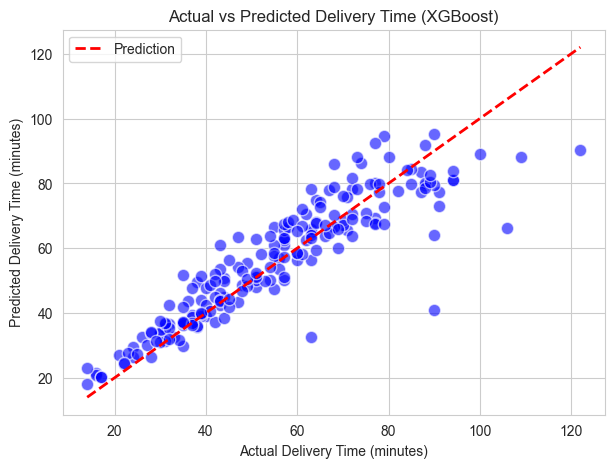

In [50]:
y_test_pred = best_xgb.predict(X_test)

plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue', edgecolors='w', s=80)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color='red', linestyle='--', linewidth=2, label='Prediction'
)
plt.xlabel("Actual Delivery Time (minutes)")
plt.ylabel("Predicted Delivery Time (minutes)")
plt.title("Actual vs Predicted Delivery Time (XGBoost)")
plt.legend()
plt.show()

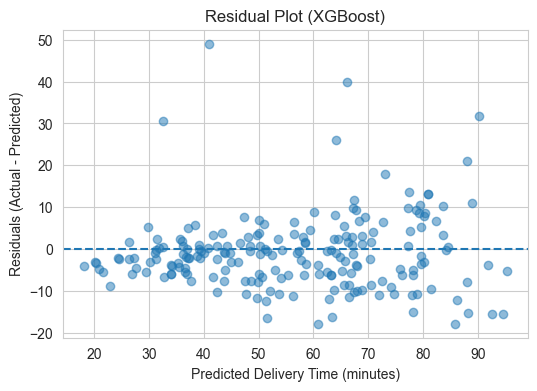

In [51]:
# Calculate residuals
y_pred_xgb = best_xgb.predict(X_test)

residuals = y_test - y_pred_xgb

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_xgb, residuals, alpha=0.5)
plt.axhline(y=0, linestyle='--')
plt.xlabel("Predicted Delivery Time (minutes)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (XGBoost)")
plt.show()

##### The residual plot shows that errors are randomly distributed around zero, indicating no strong bias in the model. 